<a href="https://colab.research.google.com/github/jogis0/LLM_Labs/blob/master/LLM_Homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3.1

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from huggingface_hub import login

huggingface_model = "Gensyn/Qwen2.5-0.5B-Instruct" # microsoft/Phi-3-mini-4k-instruct openai-community/gpt2 TinyLlama/TinyLlama-1.1B-Chat-v1.0
login(token="<HF_TOKEN>")


model = AutoModelForCausalLM.from_pretrained(huggingface_model, torch_dtype=torch.float32, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(huggingface_model, trust_remote_code=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [ ]:
import matplotlib.pyplot as plt
import os

def get_all_weights(model):
    weights = []
    for name, param in model.named_parameters():
        if param.requires_grad and 'weight' in name:
            weights.append(param.data.view(-1))
    return torch.cat(weights)

original_weights = get_all_weights(model)

def print_model_size(mdl):
    torch.save(mdl.state_dict(), "temp_weights.pt")
    size_mb = os.path.getsize("temp_weights.pt") / float(2**20)
    print(f"Model size: {size_mb:.2f} MB")
    os.remove("temp_weights.pt")

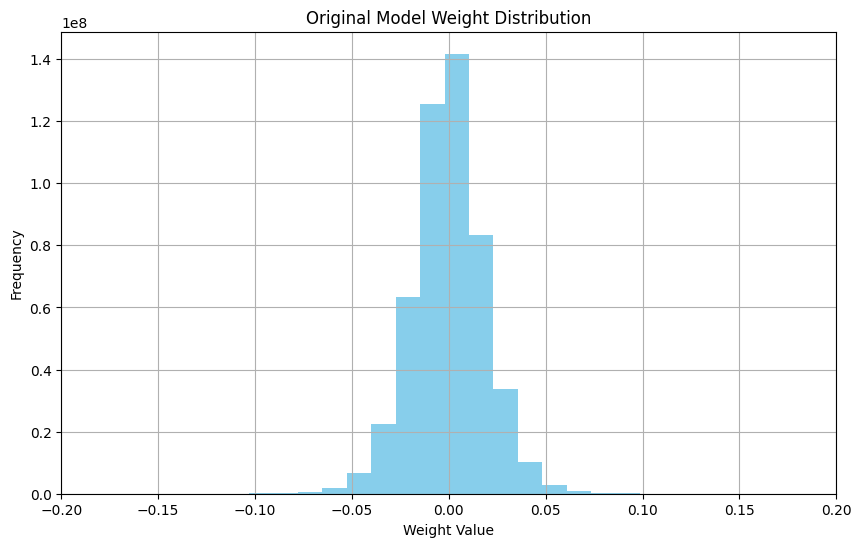

Model size: 1884.69 MB


In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(original_weights.cpu().type(torch.float32).numpy(), bins=1500, color='skyblue')
plt.title("Original Model Weight Distribution")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.xlim([-0.2, 0.2])
plt.show()
print_model_size(model)


In [ ]:
import gc

original_pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
story_prompt = "Finish the story: Once upon a time there was a boy"
messages = [
    {
        "role": "user",
        "content": story_prompt,
    }
]

generation_args = {
    "max_new_tokens": 50,
    "return_full_text": False
}

original_result = original_pipe(messages, **generation_args)
original_response_pipe = original_result[0]['generated_text']

print(f"Original model response:\n{original_response_pipe}")
del original_pipe
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Device set to use cpu


Original model response:
Once upon a time there was a boy named Jack who lived in a small village nestled between rolling hills and whispering woods. He had long, curly brown hair that framed his face like a sunbeam, and his eyes sparkled with a kind of


In [ ]:
import torch.quantization

quantized_model = torch.quantization.quantize_dynamic(
    model,
    {torch.nn.Linear}, # layers
    dtype=torch.qint8 # quantization type
)

del model
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

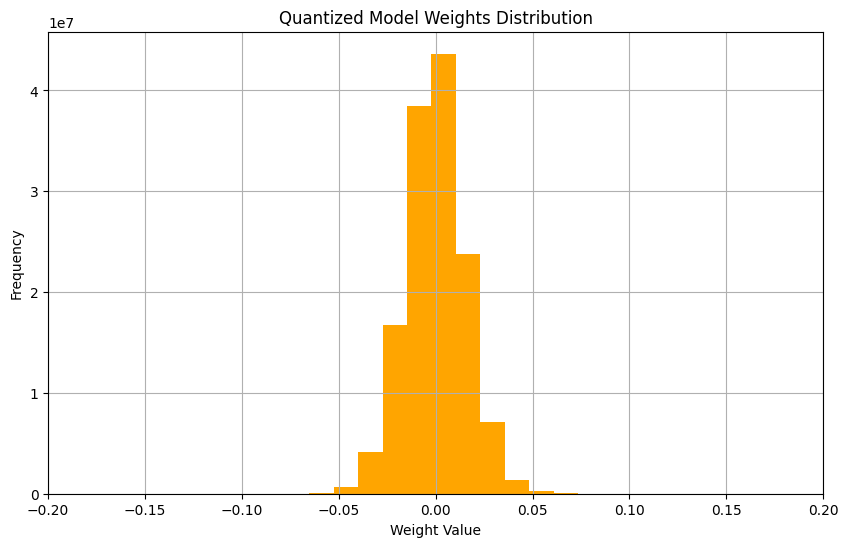

In [ ]:
quantized_weights = get_all_weights(quantized_model)

plt.figure(figsize=(10, 6))
plt.hist(quantized_weights.cpu().type(torch.float32).numpy(), bins=1500, color='orange')
plt.title("Quantized Model Weights Distribution")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.xlim([-0.2, 0.2])
plt.show()
print_model_size(quantized_model)

In [ ]:
dequantized_model = torch.quantization.quantize_dynamic(
    quantized_model,
    {torch.nn.Linear}, # layers
    dtype=torch.float32 # quantization type
)

dequantized_pipe = pipeline("text-generation", model=dequantized_model, tokenizer=tokenizer)
dequantized_result = dequantized_pipe(messages, **generation_args)
dequantized_response_pipe = dequantized_result[0]['generated_text']

print(f"Quantized model response:\n{dequantized_response_pipe}")

Device set to use cpu


RuntimeError: expected scalar type Float but found Half

#3.2

In [ ]:
pip install pandas sentence-transformers scikit-learn

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
import numpy as np

model = SentenceTransformer('all-mpnet-base-v2')

with open("paragraphs.txt", "r", encoding="utf-8") as f:
    original_paragraphs = [p.strip() for p in f.read().split('\n') if p.strip()]

chunk_size = max(1, len(original_paragraphs) // 10)
chunks = [' '.join(original_paragraphs[i:i + chunk_size]) for i in range(0, len(original_paragraphs), chunk_size)]

chunk_vectors = model.encode(chunks)
df = pd.DataFrame({'chunk': chunks, 'vectors': list(chunk_vectors)})

with open("new_paragraphs.txt", "r", encoding="utf-8") as f:
    new_paragraphs = [p.strip() for p in f.read().split('\n') if p.strip()]

new_vectors = model.encode(new_paragraphs)

for i, new_para in enumerate(new_paragraphs):
    # Cosine
    distances = cosine_similarity([new_vectors[i]], chunk_vectors)[0]
    best_idx = np.argmax(distances)

    # Euclidean
    # distances = euclidean_distances([new_vectors[i]], chunk_vectors)[0]
    # best_idx = np.argmin(distances)

    # Manhattan
    # distances = manhattan_distances([new_vectors[i]], chunk_vectors)[0]
    # best_idx = np.argmin(distances)

    print(f"\n=== New Paragraph {i+1} ===")
    print(new_para)
    print("\n--- Most Similar Original Chunk ---")
    print(df.iloc[best_idx]['chunk'])
    print(f"\n(Distance: {distances[best_idx]:.4f})")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


=== New Paragraph 1 ===
At 9:34 a.m. local time, a Belarusian border guard in Brest looked up and noticed an object drifting through the skies 40 miles to the northeast, heading toward the town of Pruzhany. The guard wasn’t sure what the balloon was but thought it might pose a threat. He picked up the receiver and dialed the antiaircraft command post. When it was a few hundred feet away, the Hind veered sideways, affording a menacing view of its machine guns and the cannon mounted in its turret.

--- Most Similar Original Chunk ---
Belarus and Ukraine, however, were young nations rendered independent by the Soviet Union’s collapse not quite four years prior. Both had agreed to open their skies to the race for the first time. The Cold War’s embers had darkened, and Wallace, for one, found the idea of more room to fly enticing. He felt good about their prospects as they entered a third night with plenty of ballast to spare. Behind them, Fraenckel and Stuart-Jervis were faring just as we